# Problem
## IBM Quantum Circuit Composer
When applying a Hadamard gate to a qubit initialised in the $|0⟩$ state, the qubit is put into superposition $\frac{1}{\sqrt{2}}|0⟩ + \frac{1}{\sqrt{2}}|1⟩$, so we would expect upon measurement, for the probability histogram to reveal that there is a 50/50 probability of measuring the $|0⟩$ or $|1⟩$ state. However, the IBM Quantum Circuit Composer probability histogram shows that the $|0⟩$ state is measured with 100% probability.

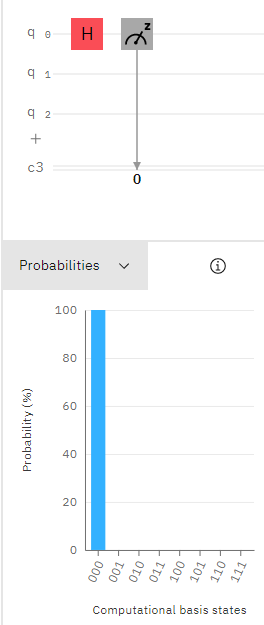


Note that this strange observance applies to more than just one qubit:

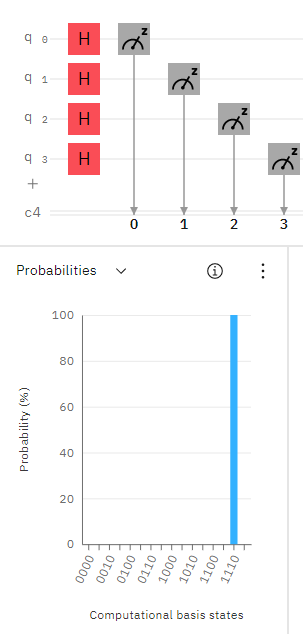


What is unusual however is that when we remove the measurement component from the circuit, the histogram reflects the 50/50 probability expected.


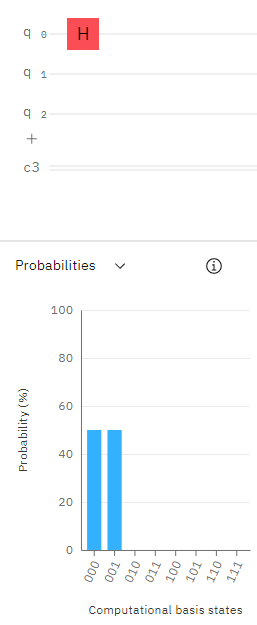

# Investigation
(01/08/21)
I have decided to implement the same quantum circuit using qiskit in a Jupyter notebook rather than IBM's Quantum Circuit Composer, to see if I would obtain different results. I have more or less kept the code the same, to allow me to determine whether this problem arises from the Circuit Composer.

In [ ]:
# Install required packages
!pip install matplotlib qiskit pylatexenc

In [2]:
# Import required libraries
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.providers.aer import QasmSimulator
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

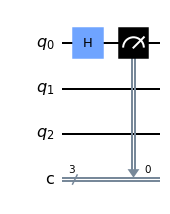

In [3]:
# Set up quantum circuit and draw diagram

qreg_q = QuantumRegister(3, 'q')
creg_c = ClassicalRegister(3, 'c')
circuit = QuantumCircuit(qreg_q, creg_c)
circuit.h(0)
circuit.measure(qreg_q[0], creg_c[0])
circuit.draw(output='mpl')

001: 529
000: 471
P(001) = 52.9%
P(000) = 47.1%


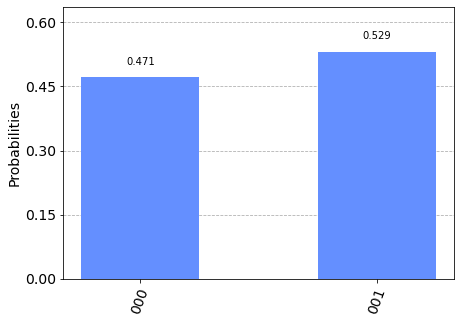

In [4]:
simulator = QasmSimulator()
compiled_circuit = transpile(circuit, simulator)
# shots is the no. of times the circuit is run
job = simulator.run(compiled_circuit, shots=1000) 
result = job.result()
counts = result.get_counts(circuit)

# printing the no. of times each state was observed along with their probabilities.
for k, v in counts.items():
  print(f'{k}: {v}')

for k, v in counts.items():
  print(f'P({k}) = {round((v/1000)*100, 3)}%')

plot_histogram(counts)



As you can see, despite setting up the same circuit, the qiskit implementation outside of IBM's Circuit Composer produces the expected probability histogram, which suggests that the issue is isolated to the Circuit Composer.

However, for this implementation of the circuit, when I remove the measure component the observed state is 100% $|0⟩$. This is understandable as the histogram needs to default to a value in case nothing is measured.

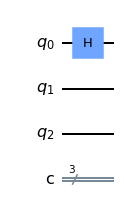

In [5]:
circuit = QuantumCircuit(QuantumRegister(3, 'q'), ClassicalRegister(3, 'c'))
circuit.h(0)
circuit.draw(output='mpl')

000: 1000
P(000) = 100.0%


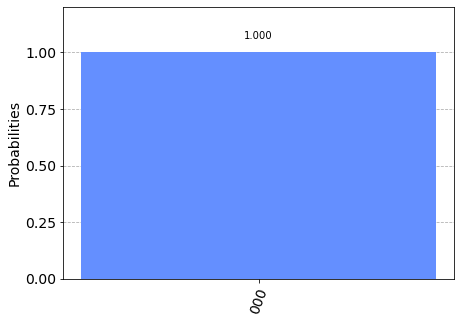

In [6]:
simulator = QasmSimulator()
compiled_circuit = transpile(circuit, simulator)

job = simulator.run(compiled_circuit, shots=1000)
result = job.result()
counts = result.get_counts(circuit)

for k, v in counts.items():
  print(f'{k}: {v}')

for k, v in counts.items():
  print(f'P({k}) = {round((v/1000)*100, 3)}%')

plot_histogram(counts)



(02/08/21) - Update

After using Google search, I have found that others are witnessing the same event. [This](https://quantumcomputing.stackexchange.com/questions/15361/simple-hadamard-circuit-gives-incorrect-results) is a link to a discussion about this issue on StackExchange.

We know that a qubit in superposition upon measurement will collapse to either the $|0⟩$ or $|1⟩$ state. As Dr Chakraborty suggested, the histogram shows a 100% probability of observing the $|0⟩$ state as this is what the qubit collapsed to upon measurement. However, my counter was that following this line of thought the histogram should also reflect the $|1⟩$ state with 100% probability, 50% of the time you run the circuit. After reading the discussion, I have found that this does not happen due to an implementation choice, the qubit in superposition has a predetermined state which it will always collapse to upon measurement.




## Conclusion

I have come to the conclusion that the 'problem' is the result of an implementation decision made by IBM.

To sum up my observations, the Circuit Composer produces the 50/50 probability histogram when no measurement component is added because it is built to automatically reflect the probabilities after a gate is applied - in other words, the histogram doesn't require a measurement component to reflect the probabilities. But once the qubit is measured it suggests that the $|0⟩$ state is observed 100%, this is because of IBM's decision to set the qubit to collapse to $|0⟩$ by default. 

On the other hand, the qiskit implementation outside of the Circuit Composer produces the expected probability diagram when the measurement component is present. However, when no measurement component is included in the circuit, the qiskit implementation produces a histogram reflecting the $|0⟩$ state 100% of the time.

